## Review sentiment analysis 1
#### Comparison of Vader, TextBlob, and Hugging Face in sentiment analysis using sample review data.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

RANDOM_STATE= 42

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

### Prepare data

In [4]:
# load cleaned review dataset
review_df = pd.read_pickle('../data/data_cleaned/cleaned_review.zip')
print(review_df.shape)

(375173, 4)


In [5]:
# get a sample data for quick access
sample_review = review_df.sample(frac=0.05, random_state= RANDOM_STATE)
print(sample_review.shape)
sample_review.head(2)

(18759, 4)


,listing_id,date,reviewer_id,comments
26051,2693700,2015-04-18,28833372,The room was absolutely charming. Not only was...
233531,26961134,2018-08-09,114166,Perfect little spot for a getaway. Loved the a...


In [6]:
# tokenize comments
def tokenize_text(text):
    
    stop_words = set(stopwords.words("english"))
    # tokenize the text
    text_tokenized = word_tokenize(text)     
    # remove stopwords and non alpha words
    text_removed_sw = [word.lower() for word in text_tokenized if (word.isalpha()) & (word.lower() not in stop_words)]
    # no stemming since we want to show the words
#     # stem each word
#     stemmer = PorterStemmer()
#     text_stemmed = [stemmer.stem(word) for word in text_removed_sw]
    return text_removed_sw

In [7]:
%%time
sample_review['comments_tokenized'] = sample_review['comments'].apply(lambda x: tokenize_text(x)).apply(' '.join)

CPU times: user 14.6 s, sys: 346 ms, total: 14.9 s
Wall time: 15 s


In [8]:
sample_review.head(2)

,listing_id,date,reviewer_id,comments,comments_tokenized
26051,2693700,2015-04-18,28833372,The room was absolutely charming. Not only was...,room absolutely charming space welcoming bed c...
233531,26961134,2018-08-09,114166,Perfect little spot for a getaway. Loved the a...,perfect little spot getaway loved autonomy com...


### Review sentiment analysis using Vader

In [9]:
# estimate polarity socre using Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def vader_polarity_score(df,col):
    vader_pol_score = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']
    df[col + '_pol_vader'] = df[col].apply(vader_pol_score)
    return df

In [10]:
%%time
sample_review = vader_polarity_score(sample_review,'comments')

CPU times: user 2min 47s, sys: 649 ms, total: 2min 48s
Wall time: 2min 49s


In [11]:
%%time
sample_review = vader_polarity_score(sample_review,'comments_tokenized')

CPU times: user 2min 12s, sys: 171 ms, total: 2min 12s
Wall time: 2min 13s


In [12]:
sample_review.head(5)

,listing_id,date,reviewer_id,comments,comments_tokenized,comments_pol_vader,comments_tokenized_pol_vader
26051,2693700,2015-04-18,28833372,The room was absolutely charming. Not only was...,room absolutely charming space welcoming bed c...,0.9757,0.9806
233531,26961134,2018-08-09,114166,Perfect little spot for a getaway. Loved the a...,perfect little spot getaway loved autonomy com...,0.9700,0.9654
230941,26804995,2022-08-23,153547993,Great place to stay in a great area!,great place stay great area,0.8588,0.8481
371448,654310843421448825,2022-07-04,24748581,We really enjoyed our stay at Vince’s place. G...,really enjoyed stay vince place great location...,0.9335,0.9299
320629,49229073,2020-12-22,136486144,Neat hotel in a great location,neat hotel great location,0.7964,0.7964


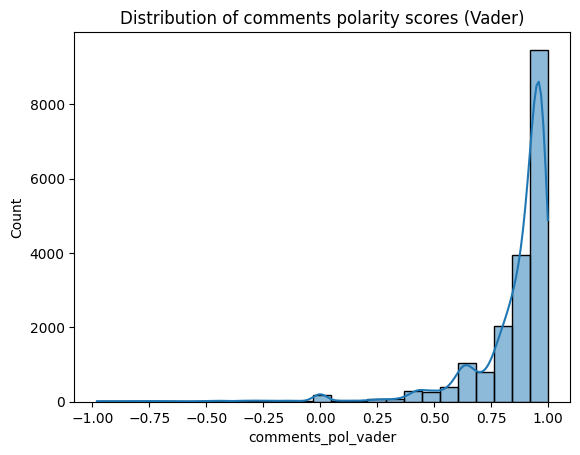

In [13]:
sns.histplot(data=sample_review, x='comments_pol_vader', bins=25, kde=True);
plt.title('Distribution of comments polarity scores (Vader)');

In [14]:
sample_review['comments_pol_vader'].describe()

count    18759.000000
mean         0.847389
std          0.211155
min         -0.979300
25%          0.821300
50%          0.920800
75%          0.963000
max          0.999000
Name: comments_pol_vader, dtype: float64

In [15]:
# check if there are some large diffences polarity score between tokenized and untokenized
condition = (sample_review['comments_pol_vader']-sample_review['comments_tokenized_pol_vader'] > 0.9)

In [16]:
dif_idx= np.where(condition)[0]
dif_idx

array([  182,  1273,  1744,  5647,  5668, 10297, 10403, 11777, 13594,
       17259])

In [17]:
dif_reviews = sample_review.iloc[dif_idx[:3]]
dif_reviews

,listing_id,date,reviewer_id,comments,comments_tokenized,comments_pol_vader,comments_tokenized_pol_vader
266959,32793488,2020-09-19,1918775,The interior design is beautiful. <br/><br/>Ho...,interior design beautiful however cleanliness ...,0.8743,-0.5259
236611,27208473,2019-12-07,34865547,From the very beginning of my booking Julia’s ...,beginning booking julia home check met nothing...,0.8201,-0.2695
309593,45960931,2022-04-08,114575481,It’s not a house nor an apartment.<br/><br/>It...,house office renovated living place noise cold...,0.6208,-0.5423


The three example polarity scores estimated on the original comments are positive, while those estimated on tokenized comments are negative. Let's see whether they should be positive or negative.

In [20]:
# idx = dif_reviews

print(dif_reviews['comments'][266959])
print('---')
print(dif_reviews['comments'][236611])
print('---')
print(dif_reviews['comments'][309593])

The interior design is beautiful. <br/><br/>However, the cleanliness of the house was totally unacceptable. When I arrived, the house smelled like a dirty kitty litter and I discovered the garbage hadn’t been taken out for a week. I reported it to Brendan and he immediately offered to take the garbage out and credit me $35. That was great. <br/><br/>It went downhill from there and I discovered so many dirty things: dirty and crusty baking sheets in the oven, both cutting boards were dirty, crumbs in the kitchen drawers, dirty dishes in the cupboards, bed nightstand wasn’t wiped down, and the only kitchen dish towel I could find smelled dirty. In a time of Covid-19 and higher sanitation standards, it made me inspect everything I touched and wonder if it’s dirty. I wanted to take a bath, but opted not to since I would need to clean the bath tub to feel comfortable. <br/><br/>I reported all these issues to Brandon and he reacted with surprise and shock, but no offers to reduce the rent or

Seem all the three commments should be positive, so the polarity scores estimated on the original comments are more accurate.

Findings:
1. Vader works better on the original text. It can handle captitalizations and punctuations(eg:LIKE, GREAT, ALL, !!).For example: the polarity score of the original comment,"ALL five stars", is 0.80 and the score of tokenized version,"five stars", is only 0.47.
2. Vader doesn't work well on some of the tokenized comments, because words like 'dont', 'no' are not in the tokenized comments. Need to include these word in the tokenized comments, and consider about bi-gram tokenization.
3. The majority polarity scores are positive with a a mean of 0.84.
    

### Review sentiment analysis using TextBlob

In [21]:
# estimate polarity socre using TextBlob
from textblob import TextBlob

def textblob_polarity_score(df,col):
    textblob_pol_score = lambda s: (TextBlob(s).sentiment.polarity)
    df[col + '_pol_textblob'] = df[col].apply(textblob_pol_score)
    return df

In [22]:
%%time
sample_review = textblob_polarity_score(sample_review,'comments_tokenized')

CPU times: user 4.62 s, sys: 31.8 ms, total: 4.66 s
Wall time: 4.67 s


In [23]:
sample_review.head(3)

,listing_id,date,reviewer_id,comments,comments_tokenized,comments_pol_vader,comments_tokenized_pol_vader,comments_tokenized_pol_textblob
26051,2693700,2015-04-18,28833372,The room was absolutely charming. Not only was...,room absolutely charming space welcoming bed c...,0.9757,0.9806,0.353347
233531,26961134,2018-08-09,114166,Perfect little spot for a getaway. Loved the a...,perfect little spot getaway loved autonomy com...,0.9700,0.9654,0.439063
230941,26804995,2022-08-23,153547993,Great place to stay in a great area!,great place stay great area,0.8588,0.8481,0.800000


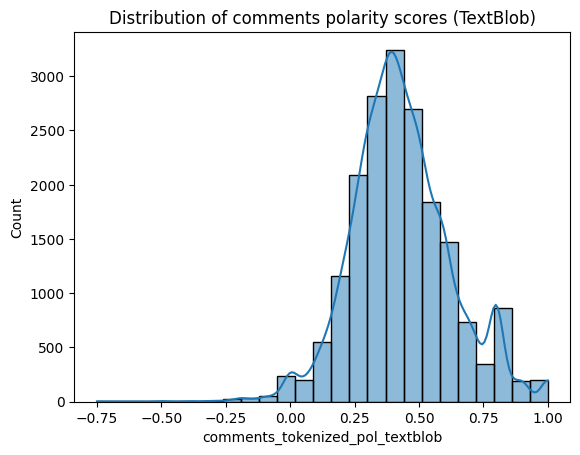

In [24]:
sns.histplot(data=sample_review, x='comments_tokenized_pol_textblob', bins=25, kde=True);
plt.title('Distribution of comments polarity scores (TextBlob)');

In [25]:
sample_review['comments_tokenized_pol_textblob'].describe()

count    18759.000000
mean         0.433056
std          0.193913
min         -0.750000
25%          0.309444
50%          0.416667
75%          0.544444
max          1.000000
Name: comments_tokenized_pol_textblob, dtype: float64

In [26]:
# check the top 5 records having polarity score (by textblob) >0.9
sample_review[sample_review['comments_tokenized_pol_textblob']>0.9].sort_values(by ='comments_tokenized_pol_textblob')[:5]

,listing_id,date,reviewer_id,comments,comments_tokenized,comments_pol_vader,comments_tokenized_pol_vader,comments_tokenized_pol_textblob
170934,17865690,2019-08-13,25230985,"Great space. Beautiful backyard oasis, wonder...",great space beautiful backyard oasis wonderful...,0.9617,0.9601,0.9125
283660,36212430,2021-02-21,303362035,Awesome and beautiful home!,awesome beautiful home,0.8516,0.8402,0.9250
184424,20889482,2019-02-25,105492371,Pam and Byron’s house was absolutely beautiful...,pam byron house absolutely beautiful downstair...,0.8475,0.8357,0.9250
100238,7745196,2018-07-10,25150372,Emily/Trevor’s place is the perfect location t...,place perfect location explore seattle heart f...,0.9358,0.9290,0.9250
225670,26466765,2022-06-27,153367900,Beautiful place !! Best views around .,beautiful place best views around,0.8652,0.8442,0.9250


In [27]:
# check how many reviews has a polarity score > 0.9 using textblob
sample_review[sample_review['comments_tokenized_pol_textblob']>0.9].sort_values(by ='comments_tokenized_pol_textblob').shape

(215, 8)

In [28]:
# check how many reviews has a polarity score > 0.9 using vader
sample_review[sample_review['comments_tokenized_pol_vader']>0.9].sort_values(by ='comments_tokenized_pol_vader').shape

(10634, 8)

Findings:
1. TextBlob doesn't handle well on the captitalizations and punctuations(eg:LIKE, GREAT, ALL, !!). For example: the polarity score of the original comment,"ALL five stars", is 0.80 and the score of tokenized version,"five stars", is only 0.47.
2. Only a small portion (239) of the comments are classified as highly positive (>0.9) compare to that of vader (10739).
3. The majority polarity scores are positive with a a mean of 0.4.

### Review sentiment analysis using HuggingFace

In [29]:
!pip install -q transformers

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [30]:
pip install --upgrade huggingface-hub

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [31]:
# use the pipeline class to make predictions 
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
# use a specific model avalible in teh huggingface
# sentiment_pipeline = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

2023-03-31 18:48:10.744601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 18:48:10.933500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 18:48:10.933543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-31 18:48:10.964539: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-31 18:48:13.331696: W tensorflow/stream_executor/pla

In [32]:
def huggingface_polarity_score(df,col):
    global sentiment_pipeline
    huggingface_pol_score = lambda s: (sentiment_pipeline(s)[0]['score'])
    df[col + '_pol_huggingface'] = df[col].apply(huggingface_pol_score)
    return df

In [33]:
%%time
# it takes too much time estimating polarity score,
# here i only use the bottom 20 reviews ordered by comments_pol_vader to see the differences
bottom_20_review = sample_review.sort_values(by='comments_pol_vader')[:20]
test_review = huggingface_polarity_score(bottom_20_review,'comments_tokenized')

CPU times: user 6.73 s, sys: 206 ms, total: 6.94 s
Wall time: 6.96 s


In [34]:
test_review['comments_pol_vader'].iloc[:5].values

array([-0.9793, -0.9792, -0.9783, -0.9758, -0.9754])

In [35]:
comments = test_review['comments_tokenized'].iloc[:5].values
for comment in comments:
    print(sentiment_pipeline(comment))

[{'label': 'NEGATIVE', 'score': 0.9973649382591248}]
[{'label': 'NEGATIVE', 'score': 0.9988445043563843}]
[{'label': 'NEGATIVE', 'score': 0.992530882358551}]
[{'label': 'NEGATIVE', 'score': 0.9623371362686157}]
[{'label': 'NEGATIVE', 'score': 0.9984685778617859}]


Findings:
1. Huggingface takes much more time to estimate the polarity scores comparing to Vader and TextBlob.
2. Huggingface sentiment analysis has max_len of 512 for a comments, longer comments cannot be processed.
3. The scores are too close (eg: .9998, .9991), which is hard to see the difference and has more incorrect labels. 

### Conclusion:
Overall, Vader works better for a more accurate review polarity score on the original comments. It outperforms TextBlob in handling capitalizations and punctuations (e.g BAD PLACE!!!), and outperforms Hugging face in terms of resource consumption (word limitation and long time to run).

Next, We will apply Vader to the entire cleaned_review dataset to do review sentiment analysis (review_sentiment_analysis notebook).




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a50dc6-ff6a-45ff-9dbe-d7a35bd1e393' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>